# ARI: LightGBM Tuning

### Setup

In [1]:
import sys
sys.path.append('../')
from src.load_data import *
from src.realtime_utils import *
from src.hp_tuning_functions import *

In [2]:
from darts.models.forecasting.lgbm import LightGBMModel

/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/statsforecast/utils.py:231: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  "ds": pd.date_range(start="1949-01-01", periods=len(AirPassengers), freq="M"),


In [3]:
import wandb
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: dwolffram (dwolffram-karlsruhe-institute-of-technology). Use `wandb login --relogin` to force relogin


True

### Configuration

In [4]:
NAME = 'lightgbm'

In [5]:
NUM_SAMPLES = 1000
HORIZON = 4

ENCODERS = {
    'datetime_attribute': {'future': ['month', 'weekofyear']}
}

SHARED_ARGS = dict(
    output_chunk_length=HORIZON,
)

In [6]:
# lags_covariates = {
#     'agi-are-DE': 8,
#     'agi-are-00-04': 8,
#     'agi-are-05-14': 8,
#     'agi-are-15-34': 8,
#     'agi-are-35-59': 8,
#     'agi-are-60+': 8,
#     'default_lags': 1
# }

In [7]:
sweep_configuration = {
    "name": f"ARI-{NAME}",
    "method": "random",
    "metric": {"goal": "minimize", "name": "WIS"},  
    "parameters": {
        "model": {"values": [NAME]},  
        "multiple_series": {"values": [False]},
        "use_covariates" :  {"values" : [True, False]},
        "use_features" :  {"values" : [False]},
        "use_encoders" :  {"values" : [True]},
        "use_static_covariates" :  {"values" : [False]},
        "sample_weight" : {"values" : [None, "linear"]},
        "lags": {"values": [8]},
        "lags_past_covariates": {"values": [8]},
        "lags_future_covariates": {"values": [(0, 1)]},
        "num_leaves": {"values": [10, 20, 31, 40, 50]},  # Number of leaves
        "max_depth": {"values": [-1, 5, 10, 15, 20]},  # Max depth of trees
        "learning_rate": {"values": [0.005, 0.01, 0.05, 0.1, 0.2]},  # Learning rate
        "n_estimators": {"values": [250, 500, 1000, 2000, 5000]},  # Number of boosting rounds
        "min_child_samples": {"values": [10, 20, 30, 40]},  # Minimum child samples per leaf
        "subsample": {"values": [0.8, 0.9, 1.0]},  # Subsampling ratio
        "colsample_bytree": {"values": [0.8, 0.9, 1.0]},  # Feature fraction for building trees
        "reg_alpha": {"values": [0, 0.25, 0.5, 1.0, 5.0]},  # L1 regularization
        "reg_lambda": {"values": [0, 0.25, 0.5, 1.0, 5.0]},  # L2 regularization
        "subsample_freq": {"values": [0, 1, 2, 5]},  # Subsampling frequency
        "min_split_gain": {"values": [0.0, 0.1, 0.2]},  # Minimum gain to split
        "max_bin": {"values": [510, 1024, 2048]},  # Maximum number of bins
    }
}

### Load data

In [8]:
covariates, targets = load_realtime_training_data()

In [9]:
targets_train, targets_validation = train_validation_split(targets, 2023)

<Axes: xlabel='date'>

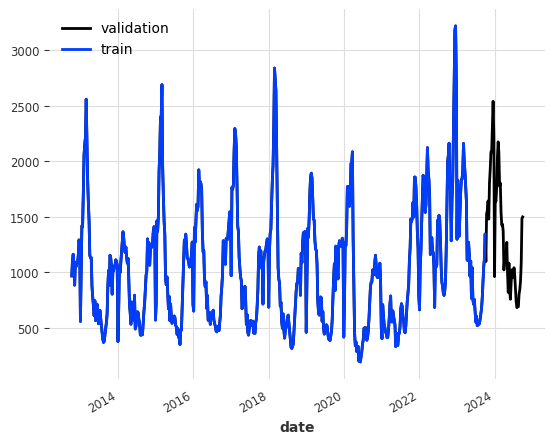

In [10]:
targets_validation['agi-are-DE'].plot(label='validation')
targets_train['agi-are-DE'].plot(label='train')

In [11]:
# Block CV
def objective(config):
    optimizer = OPTIMIZER_DICT[config.optimizer]
    use_covariates = config.use_covariates
    
    model = TSMixerModel(
        input_chunk_length=config.input_chunk_length,
        hidden_size=config.hidden_size,
        ff_size=config.ff_size,
        num_blocks=config.num_blocks,
        dropout=config.dropout,
        norm_type=config.norm_type,
        batch_size=config.batch_size,
        n_epochs=config.n_epochs,
        normalize_before=config.normalize_before,
        activation=config.activation,
        optimizer_cls=optimizer,
        optimizer_kwargs={**config.optimizer_kwargs},
        use_static_covariates=config.use_static_covariates,
        
        **SHARED_ARGS
    )
    
    scores = []
    k=0
    for train, validation, cov in zip(targets_train, targets_validation, covariates):
        k+=1
        score = compute_validation_score(model, train, validation, cov if use_covariates else None, 
                                         HORIZON, NUM_SAMPLES, METRIC, METRIC_KWARGS)
        scores.append(score)
        wandb.log({f'WIS_{k}' : score})
        # model.reset()?
            
    avg_score = np.mean(scores) # average across all validation periods
    std = np.std(scores)
    var = np.var(scores)
    
    wandb.log({'WIS_std' : std,
               'WIS_var' : var})

    return avg_score

In [12]:
RANDOM_SEEDS = [1, 2, 3]

In [13]:
# Multiple runs
def objective(config):
    optimizer = OPTIMIZER_DICT[config.optimizer]
    use_covariates = config.use_covariates
    use_features = config.use_features
    use_encoders = config.use_encoders
    
    model = TSMixerModel(
        input_chunk_length=config.input_chunk_length,
        hidden_size=config.hidden_size,
        ff_size=config.ff_size,
        num_blocks=config.num_blocks,
        dropout=config.dropout,
        norm_type=config.norm_type,
        batch_size=config.batch_size,
        n_epochs=config.n_epochs,
        normalize_before=config.normalize_before,
        activation=config.activation,
        optimizer_cls=optimizer,
        optimizer_kwargs={**config.optimizer_kwargs},
        use_static_covariates=config.use_static_covariates,
        add_encoders=ENCODERS if use_encoders else None,
        
        **SHARED_ARGS
    )
    
    train = targets_train
    validation = targets_validation
    cov = covariates
    
    if use_features:
        ts_features = load_features(lag=8)
        cov = cov.slice_intersect(ts_features) # features start a bit later because of rolling window
        ts_features = ts_features.slice_intersect(cov) # features are longer because they cover the whole period until now
    
    
    scores = []
    for seed in RANDOM_SEEDS:
        model.model_params['random_state'] = seed
        score = compute_validation_score(model, train, validation, cov if use_covariates else None, 
                                         HORIZON, NUM_SAMPLES, METRIC, METRIC_KWARGS)
        scores.append(score)
        wandb.log({f'WIS_{seed}' : score})
        model.reset_model()
            
    avg_score = np.mean(scores) # average across all runs
    std = np.std(scores)
    
    wandb.log({'WIS_std' : std})

    return avg_score

### Expanding window

In [14]:
VALIDATION_YEARS = [2022, 2023][::-1]

In [15]:
RANDOM_SEEDS = [1, 2, 3]

In [16]:
custom_weights = get_custom_weights(targets)

In [17]:
# Expanding window
def objective(config):
    multiple_series = config.multiple_series
    use_covariates = config.use_covariates
    use_features = config.use_features
    use_encoders = config.use_encoders
    sample_weight = config.sample_weight
    
    model = LightGBMModel(
        lags=config.lags,
        lags_past_covariates=config.lags_past_covariates if use_covariates else None,
        lags_future_covariates=config.lags_future_covariates if use_encoders else None,
        num_leaves=config.num_leaves,
        max_depth=config.max_depth,
        learning_rate=config.learning_rate,
        n_estimators=config.n_estimators,
        min_child_samples=config.min_child_samples, 
        subsample=config.subsample, 
        colsample_bytree=config.colsample_bytree,  
        reg_alpha=config.reg_alpha,  # L1 regularization
        reg_lambda=config.reg_lambda,  # L2 regularization
        subsample_freq=config.subsample_freq, 
        min_split_gain=config.min_split_gain,  
        max_bin=config.max_bin,  
        use_static_covariates=config.use_static_covariates,
        add_encoders=ENCODERS if use_encoders else None,
        verbose=-1,
        likelihood="quantile",
        quantiles=QUANTILES,
        
        **SHARED_ARGS
    )
    
    cov = covariates
    
    if use_features:
        cov = add_features(cov)
    
    scores = []
    for validation_year in VALIDATION_YEARS:
        targets_train, targets_validation = train_validation_split(targets, validation_year)
        scores_year = []
        for seed in RANDOM_SEEDS:
            model.model_params['random_state'] = seed
            
            score = compute_validation_score(model, targets_train, targets_validation, covariates if use_covariates else None, 
                                             HORIZON, NUM_SAMPLES, METRIC, METRIC_KWARGS,
                                             sample_weight=custom_weights if sample_weight == "custom" else sample_weight)
            scores.append(score)
            scores_year.append(score)
            wandb.log({f'WIS_{validation_year}_{seed}' : score})
            
        
        wandb.log({f'WIS_{validation_year}' : np.mean(scores_year)})
        wandb.log({f'WIS_std_{validation_year}' : np.std(scores_year)})
            
    avg_score = np.mean(scores) # average across all runs
    std = np.std(scores)
    
    wandb.log({'WIS_std' : std})

    return avg_score

### Run tuning

In [18]:
def main():
    run = wandb.init()
    score = objective(wandb.config)
    wandb.log({"WIS": score})
    run.finish()

In [19]:
sweep_id = wandb.sweep(sweep=sweep_configuration, project="ari-lightgbm")

Create sweep with ID: me2h5ytc
Sweep URL: https://wandb.ai/dwolffram-karlsruhe-institute-of-technology/ari-lightgbm/sweeps/me2h5ytc


In [ ]:
wandb.agent(sweep_id, function=main, count=1000)

wandb: Agent Starting Run: 3ro2l0ya with config:
wandb: 	colsample_bytree: 1
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: 8
wandb: 	learning_rate: 0.005
wandb: 	max_bin: 2048
wandb: 	max_depth: 20
wandb: 	min_child_samples: 30
wandb: 	min_split_gain: 0.1
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 2000
wandb: 	num_leaves: 20
wandb: 	reg_alpha: 0.5
wandb: 	reg_lambda: 0.25
wandb: 	sample_weight: None
wandb: 	subsample: 1
wandb: 	subsample_freq: 0
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2022,▁
WIS_2022_1,▁
WIS_2022_2,▁
WIS_2022_3,▁
WIS_2023,▁
WIS_2023_1,▁
WIS_2023_2,▁
WIS_2023_3,▁
WIS_std,▁
WIS_std_2022,▁


wandb: Agent Starting Run: zi8mcvit with config:
wandb: 	colsample_bytree: 0.8
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: 8
wandb: 	learning_rate: 0.01
wandb: 	max_bin: 510
wandb: 	max_depth: 5
wandb: 	min_child_samples: 40
wandb: 	min_split_gain: 0.2
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 250
wandb: 	num_leaves: 10
wandb: 	reg_alpha: 0.5
wandb: 	reg_lambda: 0
wandb: 	sample_weight: None
wandb: 	subsample: 0.8
wandb: 	subsample_freq: 0
wandb: 	use_covariates: False
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2022,▁
WIS_2022_1,▁
WIS_2022_2,▁
WIS_2022_3,▁
WIS_2023,▁
WIS_2023_1,▁
WIS_2023_2,▁
WIS_2023_3,▁
WIS_std,▁
WIS_std_2022,▁


wandb: Agent Starting Run: 101336w9 with config:
wandb: 	colsample_bytree: 0.9
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: 8
wandb: 	learning_rate: 0.005
wandb: 	max_bin: 510
wandb: 	max_depth: 10
wandb: 	min_child_samples: 30
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 250
wandb: 	num_leaves: 50
wandb: 	reg_alpha: 0
wandb: 	reg_lambda: 5
wandb: 	sample_weight: linear
wandb: 	subsample: 0.8
wandb: 	subsample_freq: 2
wandb: 	use_covariates: False
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2022,▁
WIS_2022_1,▁
WIS_2022_2,▁
WIS_2022_3,▁
WIS_2023,▁
WIS_2023_1,▁
WIS_2023_2,▁
WIS_2023_3,▁
WIS_std,▁
WIS_std_2022,▁


wandb: Agent Starting Run: v6teujay with config:
wandb: 	colsample_bytree: 1
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: 8
wandb: 	learning_rate: 0.005
wandb: 	max_bin: 510
wandb: 	max_depth: 15
wandb: 	min_child_samples: 10
wandb: 	min_split_gain: 0.1
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 2000
wandb: 	num_leaves: 20
wandb: 	reg_alpha: 0
wandb: 	reg_lambda: 0.25
wandb: 	sample_weight: linear
wandb: 	subsample: 1
wandb: 	subsample_freq: 2
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2022,▁
WIS_2022_1,▁
WIS_2022_2,▁
WIS_2022_3,▁
WIS_2023,▁
WIS_2023_1,▁
WIS_2023_2,▁
WIS_2023_3,▁
WIS_std,▁
WIS_std_2022,▁


wandb: Agent Starting Run: ghu1pw07 with config:
wandb: 	colsample_bytree: 1
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: 8
wandb: 	learning_rate: 0.1
wandb: 	max_bin: 1024
wandb: 	max_depth: -1
wandb: 	min_child_samples: 20
wandb: 	min_split_gain: 0.2
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 1000
wandb: 	num_leaves: 40
wandb: 	reg_alpha: 0.5
wandb: 	reg_lambda: 0.25
wandb: 	sample_weight: None
wandb: 	subsample: 1
wandb: 	subsample_freq: 5
wandb: 	use_covariates: False
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2022,▁
WIS_2022_1,▁
WIS_2022_2,▁
WIS_2022_3,▁
WIS_2023,▁
WIS_2023_1,▁
WIS_2023_2,▁
WIS_2023_3,▁
WIS_std,▁
WIS_std_2022,▁


wandb: Agent Starting Run: lckj0vbz with config:
wandb: 	colsample_bytree: 0.9
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: 8
wandb: 	learning_rate: 0.05
wandb: 	max_bin: 510
wandb: 	max_depth: 20
wandb: 	min_child_samples: 40
wandb: 	min_split_gain: 0.1
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 2000
wandb: 	num_leaves: 31
wandb: 	reg_alpha: 1
wandb: 	reg_lambda: 1
wandb: 	sample_weight: None
wandb: 	subsample: 0.9
wandb: 	subsample_freq: 0
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2022,▁
WIS_2022_1,▁
WIS_2022_2,▁
WIS_2022_3,▁
WIS_2023,▁
WIS_2023_1,▁
WIS_2023_2,▁
WIS_2023_3,▁
WIS_std,▁
WIS_std_2022,▁


wandb: Agent Starting Run: j19c1tce with config:
wandb: 	colsample_bytree: 1
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: 8
wandb: 	learning_rate: 0.01
wandb: 	max_bin: 2048
wandb: 	max_depth: 20
wandb: 	min_child_samples: 20
wandb: 	min_split_gain: 0.2
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 500
wandb: 	num_leaves: 40
wandb: 	reg_alpha: 0
wandb: 	reg_lambda: 0.25
wandb: 	sample_weight: linear
wandb: 	subsample: 1
wandb: 	subsample_freq: 2
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2022,▁
WIS_2022_1,▁
WIS_2022_2,▁
WIS_2022_3,▁
WIS_2023,▁
WIS_2023_1,▁
WIS_2023_2,▁
WIS_2023_3,▁
WIS_std,▁
WIS_std_2022,▁


wandb: Agent Starting Run: nkpno7we with config:
wandb: 	colsample_bytree: 0.9
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: 8
wandb: 	learning_rate: 0.01
wandb: 	max_bin: 1024
wandb: 	max_depth: 20
wandb: 	min_child_samples: 10
wandb: 	min_split_gain: 0.1
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 5000
wandb: 	num_leaves: 10
wandb: 	reg_alpha: 0.5
wandb: 	reg_lambda: 0
wandb: 	sample_weight: linear
wandb: 	subsample: 0.8
wandb: 	subsample_freq: 0
wandb: 	use_covariates: False
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2022,▁
WIS_2022_1,▁
WIS_2022_2,▁
WIS_2022_3,▁
WIS_2023,▁
WIS_2023_1,▁
WIS_2023_2,▁
WIS_2023_3,▁
WIS_std,▁
WIS_std_2022,▁


wandb: Agent Starting Run: y78jcn51 with config:
wandb: 	colsample_bytree: 1
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: 8
wandb: 	learning_rate: 0.2
wandb: 	max_bin: 2048
wandb: 	max_depth: 10
wandb: 	min_child_samples: 10
wandb: 	min_split_gain: 0.2
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 1000
wandb: 	num_leaves: 50
wandb: 	reg_alpha: 1
wandb: 	reg_lambda: 1
wandb: 	sample_weight: linear
wandb: 	subsample: 0.8
wandb: 	subsample_freq: 1
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2022,▁
WIS_2022_1,▁
WIS_2022_2,▁
WIS_2022_3,▁
WIS_2023,▁
WIS_2023_1,▁
WIS_2023_2,▁
WIS_2023_3,▁
WIS_std,▁
WIS_std_2022,▁


wandb: Agent Starting Run: bmkn5gir with config:
wandb: 	colsample_bytree: 0.9
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: 8
wandb: 	learning_rate: 0.1
wandb: 	max_bin: 1024
wandb: 	max_depth: 20
wandb: 	min_child_samples: 30
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 2000
wandb: 	num_leaves: 20
wandb: 	reg_alpha: 1
wandb: 	reg_lambda: 1
wandb: 	sample_weight: None
wandb: 	subsample: 0.9
wandb: 	subsample_freq: 1
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2022,▁
WIS_2022_1,▁
WIS_2022_2,▁
WIS_2022_3,▁
WIS_2023,▁
WIS_2023_1,▁
WIS_2023_2,▁
WIS_2023_3,▁
WIS_std,▁
WIS_std_2022,▁


wandb: Agent Starting Run: p5637m8d with config:
wandb: 	colsample_bytree: 1
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: 8
wandb: 	learning_rate: 0.1
wandb: 	max_bin: 2048
wandb: 	max_depth: 10
wandb: 	min_child_samples: 10
wandb: 	min_split_gain: 0.2
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 5000
wandb: 	num_leaves: 40
wandb: 	reg_alpha: 5
wandb: 	reg_lambda: 0.5
wandb: 	sample_weight: None
wandb: 	subsample: 0.9
wandb: 	subsample_freq: 5
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2022,▁
WIS_2022_1,▁
WIS_2022_2,▁
WIS_2022_3,▁
WIS_2023,▁
WIS_2023_1,▁
WIS_2023_2,▁
WIS_2023_3,▁
WIS_std,▁
WIS_std_2022,▁


wandb: Agent Starting Run: ptb0p58z with config:
wandb: 	colsample_bytree: 0.9
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: 8
wandb: 	learning_rate: 0.005
wandb: 	max_bin: 2048
wandb: 	max_depth: 5
wandb: 	min_child_samples: 30
wandb: 	min_split_gain: 0.2
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 500
wandb: 	num_leaves: 40
wandb: 	reg_alpha: 5
wandb: 	reg_lambda: 0.5
wandb: 	sample_weight: linear
wandb: 	subsample: 0.9
wandb: 	subsample_freq: 2
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2022,▁
WIS_2022_1,▁
WIS_2022_2,▁
WIS_2022_3,▁
WIS_2023,▁
WIS_2023_1,▁
WIS_2023_2,▁
WIS_2023_3,▁
WIS_std,▁
WIS_std_2022,▁


wandb: Agent Starting Run: cwftk23u with config:
wandb: 	colsample_bytree: 0.9
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: 8
wandb: 	learning_rate: 0.005
wandb: 	max_bin: 510
wandb: 	max_depth: -1
wandb: 	min_child_samples: 40
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 5000
wandb: 	num_leaves: 10
wandb: 	reg_alpha: 0.25
wandb: 	reg_lambda: 5
wandb: 	sample_weight: linear
wandb: 	subsample: 0.9
wandb: 	subsample_freq: 5
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2022,▁
WIS_2022_1,▁
WIS_2022_2,▁
WIS_2022_3,▁
WIS_2023,▁
WIS_2023_1,▁
WIS_2023_2,▁
WIS_2023_3,▁
WIS_std,▁
WIS_std_2022,▁


wandb: Agent Starting Run: 1mot7zc1 with config:
wandb: 	colsample_bytree: 0.8
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: 8
wandb: 	learning_rate: 0.1
wandb: 	max_bin: 2048
wandb: 	max_depth: 5
wandb: 	min_child_samples: 20
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 2000
wandb: 	num_leaves: 10
wandb: 	reg_alpha: 1
wandb: 	reg_lambda: 0.25
wandb: 	sample_weight: linear
wandb: 	subsample: 0.8
wandb: 	subsample_freq: 5
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2022,▁
WIS_2022_1,▁
WIS_2022_2,▁
WIS_2022_3,▁
WIS_2023,▁
WIS_2023_1,▁
WIS_2023_2,▁
WIS_2023_3,▁
WIS_std,▁
WIS_std_2022,▁


wandb: Agent Starting Run: whgd1x8u with config:
wandb: 	colsample_bytree: 0.8
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: 8
wandb: 	learning_rate: 0.05
wandb: 	max_bin: 1024
wandb: 	max_depth: 20
wandb: 	min_child_samples: 40
wandb: 	min_split_gain: 0.2
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 1000
wandb: 	num_leaves: 50
wandb: 	reg_alpha: 0
wandb: 	reg_lambda: 1
wandb: 	sample_weight: linear
wandb: 	subsample: 0.8
wandb: 	subsample_freq: 2
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2022,▁
WIS_2022_1,▁
WIS_2022_2,▁
WIS_2022_3,▁
WIS_2023,▁
WIS_2023_1,▁
WIS_2023_2,▁
WIS_2023_3,▁
WIS_std,▁
WIS_std_2022,▁


wandb: Agent Starting Run: 8n5vbsqd with config:
wandb: 	colsample_bytree: 1
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: 8
wandb: 	learning_rate: 0.005
wandb: 	max_bin: 510
wandb: 	max_depth: -1
wandb: 	min_child_samples: 10
wandb: 	min_split_gain: 0.1
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 500
wandb: 	num_leaves: 31
wandb: 	reg_alpha: 1
wandb: 	reg_lambda: 5
wandb: 	sample_weight: linear
wandb: 	subsample: 0.9
wandb: 	subsample_freq: 5
wandb: 	use_covariates: False
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2022,▁
WIS_2022_1,▁
WIS_2022_2,▁
WIS_2022_3,▁
WIS_2023,▁
WIS_2023_1,▁
WIS_2023_2,▁
WIS_2023_3,▁
WIS_std,▁
WIS_std_2022,▁


wandb: Agent Starting Run: hnhs2dvx with config:
wandb: 	colsample_bytree: 1
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: 8
wandb: 	learning_rate: 0.05
wandb: 	max_bin: 1024
wandb: 	max_depth: -1
wandb: 	min_child_samples: 40
wandb: 	min_split_gain: 0.2
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 250
wandb: 	num_leaves: 40
wandb: 	reg_alpha: 0
wandb: 	reg_lambda: 0
wandb: 	sample_weight: None
wandb: 	subsample: 1
wandb: 	subsample_freq: 1
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2022,▁
WIS_2022_1,▁
WIS_2022_2,▁
WIS_2022_3,▁
WIS_2023,▁
WIS_2023_1,▁
WIS_2023_2,▁
WIS_2023_3,▁
WIS_std,▁
WIS_std_2022,▁


wandb: Agent Starting Run: hydqaupd with config:
wandb: 	colsample_bytree: 1
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: 8
wandb: 	learning_rate: 0.01
wandb: 	max_bin: 2048
wandb: 	max_depth: 10
wandb: 	min_child_samples: 10
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 5000
wandb: 	num_leaves: 10
wandb: 	reg_alpha: 1
wandb: 	reg_lambda: 0
wandb: 	sample_weight: None
wandb: 	subsample: 1
wandb: 	subsample_freq: 5
wandb: 	use_covariates: False
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2022,▁
WIS_2022_1,▁
WIS_2022_2,▁
WIS_2022_3,▁
WIS_2023,▁
WIS_2023_1,▁
WIS_2023_2,▁
WIS_2023_3,▁
WIS_std,▁
WIS_std_2022,▁


wandb: Agent Starting Run: 5dbpwhio with config:
wandb: 	colsample_bytree: 0.9
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: 8
wandb: 	learning_rate: 0.2
wandb: 	max_bin: 510
wandb: 	max_depth: 5
wandb: 	min_child_samples: 10
wandb: 	min_split_gain: 0.1
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 2000
wandb: 	num_leaves: 20
wandb: 	reg_alpha: 5
wandb: 	reg_lambda: 5
wandb: 	sample_weight: linear
wandb: 	subsample: 0.8
wandb: 	subsample_freq: 2
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2022,▁
WIS_2022_1,▁
WIS_2022_2,▁
WIS_2022_3,▁
WIS_2023,▁
WIS_2023_1,▁
WIS_2023_2,▁
WIS_2023_3,▁
WIS_std,▁
WIS_std_2022,▁


wandb: Agent Starting Run: z6iocfp1 with config:
wandb: 	colsample_bytree: 0.8
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: 8
wandb: 	learning_rate: 0.1
wandb: 	max_bin: 510
wandb: 	max_depth: 5
wandb: 	min_child_samples: 40
wandb: 	min_split_gain: 0.2
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 250
wandb: 	num_leaves: 20
wandb: 	reg_alpha: 5
wandb: 	reg_lambda: 0.25
wandb: 	sample_weight: linear
wandb: 	subsample: 1
wandb: 	subsample_freq: 0
wandb: 	use_covariates: False
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2022,▁
WIS_2022_1,▁
WIS_2022_2,▁
WIS_2022_3,▁
WIS_2023,▁
WIS_2023_1,▁
WIS_2023_2,▁
WIS_2023_3,▁
WIS_std,▁
WIS_std_2022,▁


wandb: Agent Starting Run: mxu0dzqm with config:
wandb: 	colsample_bytree: 1
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: 8
wandb: 	learning_rate: 0.1
wandb: 	max_bin: 1024
wandb: 	max_depth: 10
wandb: 	min_child_samples: 40
wandb: 	min_split_gain: 0.1
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 1000
wandb: 	num_leaves: 10
wandb: 	reg_alpha: 0.5
wandb: 	reg_lambda: 0.25
wandb: 	sample_weight: linear
wandb: 	subsample: 1
wandb: 	subsample_freq: 5
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2022,▁
WIS_2022_1,▁
WIS_2022_2,▁
WIS_2022_3,▁
WIS_2023,▁
WIS_2023_1,▁
WIS_2023_2,▁
WIS_2023_3,▁
WIS_std,▁
WIS_std_2022,▁


wandb: Agent Starting Run: m8564rph with config:
wandb: 	colsample_bytree: 0.9
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: 8
wandb: 	learning_rate: 0.005
wandb: 	max_bin: 510
wandb: 	max_depth: -1
wandb: 	min_child_samples: 30
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 1000
wandb: 	num_leaves: 10
wandb: 	reg_alpha: 1
wandb: 	reg_lambda: 0.5
wandb: 	sample_weight: linear
wandb: 	subsample: 0.8
wandb: 	subsample_freq: 5
wandb: 	use_covariates: False
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2022,▁
WIS_2022_1,▁
WIS_2022_2,▁
WIS_2022_3,▁
WIS_2023,▁
WIS_2023_1,▁
WIS_2023_2,▁
WIS_2023_3,▁
WIS_std,▁
WIS_std_2022,▁


wandb: Agent Starting Run: ka78ckvt with config:
wandb: 	colsample_bytree: 0.8
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: 8
wandb: 	learning_rate: 0.05
wandb: 	max_bin: 510
wandb: 	max_depth: 10
wandb: 	min_child_samples: 30
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 500
wandb: 	num_leaves: 40
wandb: 	reg_alpha: 0
wandb: 	reg_lambda: 0.25
wandb: 	sample_weight: linear
wandb: 	subsample: 1
wandb: 	subsample_freq: 5
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2022,▁
WIS_2022_1,▁
WIS_2022_2,▁
WIS_2022_3,▁
WIS_2023,▁
WIS_2023_1,▁
WIS_2023_2,▁
WIS_2023_3,▁
WIS_std,▁
WIS_std_2022,▁


wandb: Agent Starting Run: b145f9vd with config:
wandb: 	colsample_bytree: 0.8
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: 8
wandb: 	learning_rate: 0.2
wandb: 	max_bin: 510
wandb: 	max_depth: 5
wandb: 	min_child_samples: 10
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 1000
wandb: 	num_leaves: 20
wandb: 	reg_alpha: 0.25
wandb: 	reg_lambda: 1
wandb: 	sample_weight: None
wandb: 	subsample: 0.9
wandb: 	subsample_freq: 1
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2022,▁
WIS_2022_1,▁
WIS_2022_2,▁
WIS_2022_3,▁
WIS_2023,▁
WIS_2023_1,▁
WIS_2023_2,▁
WIS_2023_3,▁
WIS_std,▁
WIS_std_2022,▁


wandb: Agent Starting Run: cylrj5d6 with config:
wandb: 	colsample_bytree: 1
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: 8
wandb: 	learning_rate: 0.005
wandb: 	max_bin: 2048
wandb: 	max_depth: -1
wandb: 	min_child_samples: 10
wandb: 	min_split_gain: 0.2
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 500
wandb: 	num_leaves: 40
wandb: 	reg_alpha: 0
wandb: 	reg_lambda: 0
wandb: 	sample_weight: None
wandb: 	subsample: 0.9
wandb: 	subsample_freq: 1
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2022,▁
WIS_2022_1,▁
WIS_2022_2,▁
WIS_2022_3,▁
WIS_2023,▁
WIS_2023_1,▁
WIS_2023_2,▁
WIS_2023_3,▁
WIS_std,▁
WIS_std_2022,▁


wandb: Agent Starting Run: dilcpr76 with config:
wandb: 	colsample_bytree: 1
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: 8
wandb: 	learning_rate: 0.01
wandb: 	max_bin: 1024
wandb: 	max_depth: 5
wandb: 	min_child_samples: 10
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 5000
wandb: 	num_leaves: 50
wandb: 	reg_alpha: 5
wandb: 	reg_lambda: 1
wandb: 	sample_weight: linear
wandb: 	subsample: 0.8
wandb: 	subsample_freq: 2
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2022,▁
WIS_2022_1,▁
WIS_2022_2,▁
WIS_2022_3,▁
WIS_2023,▁
WIS_2023_1,▁
WIS_2023_2,▁
WIS_2023_3,▁
WIS_std,▁
WIS_std_2022,▁


wandb: Agent Starting Run: q3g0bvqf with config:
wandb: 	colsample_bytree: 0.9
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: 8
wandb: 	learning_rate: 0.005
wandb: 	max_bin: 510
wandb: 	max_depth: 10
wandb: 	min_child_samples: 10
wandb: 	min_split_gain: 0.1
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 1000
wandb: 	num_leaves: 31
wandb: 	reg_alpha: 1
wandb: 	reg_lambda: 1
wandb: 	sample_weight: linear
wandb: 	subsample: 0.8
wandb: 	subsample_freq: 0
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2022,▁
WIS_2022_1,▁
WIS_2022_2,▁
WIS_2022_3,▁
WIS_2023,▁
WIS_2023_1,▁
WIS_2023_2,▁
WIS_2023_3,▁
WIS_std,▁
WIS_std_2022,▁


wandb: Agent Starting Run: kjjw7zqx with config:
wandb: 	colsample_bytree: 0.9
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: 8
wandb: 	learning_rate: 0.005
wandb: 	max_bin: 1024
wandb: 	max_depth: -1
wandb: 	min_child_samples: 20
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 250
wandb: 	num_leaves: 50
wandb: 	reg_alpha: 0
wandb: 	reg_lambda: 0
wandb: 	sample_weight: None
wandb: 	subsample: 0.9
wandb: 	subsample_freq: 1
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2022,▁
WIS_2022_1,▁
WIS_2022_2,▁
WIS_2022_3,▁
WIS_2023,▁
WIS_2023_1,▁
WIS_2023_2,▁
WIS_2023_3,▁
WIS_std,▁
WIS_std_2022,▁


wandb: Agent Starting Run: xrmj78nw with config:
wandb: 	colsample_bytree: 0.9
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: 8
wandb: 	learning_rate: 0.005
wandb: 	max_bin: 510
wandb: 	max_depth: 5
wandb: 	min_child_samples: 10
wandb: 	min_split_gain: 0.1
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 250
wandb: 	num_leaves: 10
wandb: 	reg_alpha: 0.25
wandb: 	reg_lambda: 0.5
wandb: 	sample_weight: linear
wandb: 	subsample: 1
wandb: 	subsample_freq: 5
wandb: 	use_covariates: False
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2022,▁
WIS_2022_1,▁
WIS_2022_2,▁
WIS_2022_3,▁
WIS_2023,▁
WIS_2023_1,▁
WIS_2023_2,▁
WIS_2023_3,▁
WIS_std,▁
WIS_std_2022,▁


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: sbpoeagk with config:
wandb: 	colsample_bytree: 0.9
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: 8
wandb: 	learning_rate: 0.1
wandb: 	max_bin: 510
wandb: 	max_depth: 15
wandb: 	min_child_samples: 20
wandb: 	min_split_gain: 0.1
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 250
wandb: 	num_leaves: 50
wandb: 	reg_alpha: 0
wandb: 	reg_lambda: 1
wandb: 	sample_weight: None
wandb: 	subsample: 1
wandb: 	subsample_freq: 5
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2022,▁
WIS_2022_1,▁
WIS_2022_2,▁
WIS_2022_3,▁
WIS_2023,▁
WIS_2023_1,▁
WIS_2023_2,▁
WIS_2023_3,▁
WIS_std,▁
WIS_std_2022,▁


wandb: Agent Starting Run: w8gfu868 with config:
wandb: 	colsample_bytree: 0.9
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: 8
wandb: 	learning_rate: 0.2
wandb: 	max_bin: 1024
wandb: 	max_depth: 5
wandb: 	min_child_samples: 30
wandb: 	min_split_gain: 0.2
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 250
wandb: 	num_leaves: 40
wandb: 	reg_alpha: 0.5
wandb: 	reg_lambda: 5
wandb: 	sample_weight: None
wandb: 	subsample: 0.8
wandb: 	subsample_freq: 0
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2022,▁
WIS_2022_1,▁
WIS_2022_2,▁
WIS_2022_3,▁
WIS_2023,▁
WIS_2023_1,▁
WIS_2023_2,▁
WIS_2023_3,▁
WIS_std,▁
WIS_std_2022,▁


wandb: Agent Starting Run: 4qgpmgtd with config:
wandb: 	colsample_bytree: 1
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: 8
wandb: 	learning_rate: 0.2
wandb: 	max_bin: 1024
wandb: 	max_depth: 5
wandb: 	min_child_samples: 30
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 2000
wandb: 	num_leaves: 10
wandb: 	reg_alpha: 0.5
wandb: 	reg_lambda: 0.25
wandb: 	sample_weight: linear
wandb: 	subsample: 0.9
wandb: 	subsample_freq: 2
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2022,▁
WIS_2022_1,▁
WIS_2022_2,▁
WIS_2022_3,▁
WIS_2023,▁
WIS_2023_1,▁
WIS_2023_2,▁
WIS_2023_3,▁
WIS_std,▁
WIS_std_2022,▁


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: mp7uya2m with config:
wandb: 	colsample_bytree: 0.8
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: 8
wandb: 	learning_rate: 0.01
wandb: 	max_bin: 1024
wandb: 	max_depth: 10
wandb: 	min_child_samples: 10
wandb: 	min_split_gain: 0.2
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 250
wandb: 	num_leaves: 20
wandb: 	reg_alpha: 0.25
wandb: 	reg_lambda: 0.25
wandb: 	sample_weight: linear
wandb: 	subsample: 0.9
wandb: 	subsample_freq: 1
wandb: 	use_covariates: False
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2022,▁
WIS_2022_1,▁
WIS_2022_2,▁
WIS_2022_3,▁
WIS_2023,▁
WIS_2023_1,▁
WIS_2023_2,▁
WIS_2023_3,▁
WIS_std,▁
WIS_std_2022,▁


wandb: Agent Starting Run: rfocroc1 with config:
wandb: 	colsample_bytree: 1
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: 8
wandb: 	learning_rate: 0.2
wandb: 	max_bin: 1024
wandb: 	max_depth: 20
wandb: 	min_child_samples: 40
wandb: 	min_split_gain: 0.1
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 2000
wandb: 	num_leaves: 50
wandb: 	reg_alpha: 0
wandb: 	reg_lambda: 0.5
wandb: 	sample_weight: linear
wandb: 	subsample: 0.8
wandb: 	subsample_freq: 0
wandb: 	use_covariates: False
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2022,▁
WIS_2022_1,▁
WIS_2022_2,▁
WIS_2022_3,▁
WIS_2023,▁
WIS_2023_1,▁
WIS_2023_2,▁
WIS_2023_3,▁
WIS_std,▁
WIS_std_2022,▁


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ly03adav with config:
wandb: 	colsample_bytree: 0.9
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: 8
wandb: 	learning_rate: 0.2
wandb: 	max_bin: 510
wandb: 	max_depth: 15
wandb: 	min_child_samples: 40
wandb: 	min_split_gain: 0.2
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 5000
wandb: 	num_leaves: 50
wandb: 	reg_alpha: 0.25
wandb: 	reg_lambda: 0.5
wandb: 	sample_weight: None
wandb: 	subsample: 0.8
wandb: 	subsample_freq: 2
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2022,▁
WIS_2022_1,▁
WIS_2022_2,▁
WIS_2022_3,▁
WIS_2023,▁
WIS_2023_1,▁
WIS_2023_2,▁
WIS_2023_3,▁
WIS_std,▁
WIS_std_2022,▁


wandb: Agent Starting Run: sht275jc with config:
wandb: 	colsample_bytree: 1
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: 8
wandb: 	learning_rate: 0.1
wandb: 	max_bin: 1024
wandb: 	max_depth: 20
wandb: 	min_child_samples: 20
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 1000
wandb: 	num_leaves: 10
wandb: 	reg_alpha: 0.5
wandb: 	reg_lambda: 1
wandb: 	sample_weight: None
wandb: 	subsample: 0.8
wandb: 	subsample_freq: 5
wandb: 	use_covariates: False
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2022,▁
WIS_2022_1,▁
WIS_2022_2,▁
WIS_2022_3,▁
WIS_2023,▁
WIS_2023_1,▁
WIS_2023_2,▁
WIS_2023_3,▁
WIS_std,▁
WIS_std_2022,▁


wandb: Agent Starting Run: 8ikxh8bf with config:
wandb: 	colsample_bytree: 0.9
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: 8
wandb: 	learning_rate: 0.005
wandb: 	max_bin: 2048
wandb: 	max_depth: 20
wandb: 	min_child_samples: 40
wandb: 	min_split_gain: 0.1
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 1000
wandb: 	num_leaves: 20
wandb: 	reg_alpha: 5
wandb: 	reg_lambda: 0.5
wandb: 	sample_weight: None
wandb: 	subsample: 1
wandb: 	subsample_freq: 1
wandb: 	use_covariates: False
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2022,▁
WIS_2022_1,▁
WIS_2022_2,▁
WIS_2022_3,▁
WIS_2023,▁
WIS_2023_1,▁
WIS_2023_2,▁
WIS_2023_3,▁
WIS_std,▁
WIS_std_2022,▁


wandb: Agent Starting Run: rizvb7a2 with config:
wandb: 	colsample_bytree: 0.8
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: 8
wandb: 	learning_rate: 0.05
wandb: 	max_bin: 510
wandb: 	max_depth: 10
wandb: 	min_child_samples: 20
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 500
wandb: 	num_leaves: 10
wandb: 	reg_alpha: 1
wandb: 	reg_lambda: 0.25
wandb: 	sample_weight: linear
wandb: 	subsample: 0.9
wandb: 	subsample_freq: 5
wandb: 	use_covariates: False
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2022,▁
WIS_2022_1,▁
WIS_2022_2,▁
WIS_2022_3,▁
WIS_2023,▁
WIS_2023_1,▁
WIS_2023_2,▁
WIS_2023_3,▁
WIS_std,▁
WIS_std_2022,▁


wandb: Agent Starting Run: pipmg2hv with config:
wandb: 	colsample_bytree: 0.8
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: 8
wandb: 	learning_rate: 0.005
wandb: 	max_bin: 1024
wandb: 	max_depth: -1
wandb: 	min_child_samples: 40
wandb: 	min_split_gain: 0.2
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 2000
wandb: 	num_leaves: 50
wandb: 	reg_alpha: 0
wandb: 	reg_lambda: 1
wandb: 	sample_weight: None
wandb: 	subsample: 1
wandb: 	subsample_freq: 5
wandb: 	use_covariates: False
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2022,▁
WIS_2022_1,▁
WIS_2022_2,▁
WIS_2022_3,▁
WIS_2023,▁
WIS_2023_1,▁
WIS_2023_2,▁
WIS_2023_3,▁
WIS_std,▁
WIS_std_2022,▁


wandb: Agent Starting Run: i52buc39 with config:
wandb: 	colsample_bytree: 0.9
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: 8
wandb: 	learning_rate: 0.2
wandb: 	max_bin: 1024
wandb: 	max_depth: 20
wandb: 	min_child_samples: 20
wandb: 	min_split_gain: 0.2
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 250
wandb: 	num_leaves: 50
wandb: 	reg_alpha: 0.25
wandb: 	reg_lambda: 5
wandb: 	sample_weight: linear
wandb: 	subsample: 0.9
wandb: 	subsample_freq: 1
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2022,▁
WIS_2022_1,▁
WIS_2022_2,▁
WIS_2022_3,▁
WIS_2023,▁
WIS_2023_1,▁
WIS_2023_2,▁
WIS_2023_3,▁
WIS_std,▁
WIS_std_2022,▁


wandb: Agent Starting Run: ij9svkvo with config:
wandb: 	colsample_bytree: 0.9
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: 8
wandb: 	learning_rate: 0.1
wandb: 	max_bin: 510
wandb: 	max_depth: -1
wandb: 	min_child_samples: 30
wandb: 	min_split_gain: 0.2
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 5000
wandb: 	num_leaves: 31
wandb: 	reg_alpha: 0.25
wandb: 	reg_lambda: 1
wandb: 	sample_weight: linear
wandb: 	subsample: 0.8
wandb: 	subsample_freq: 1
wandb: 	use_covariates: False
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
